<a href="https://colab.research.google.com/github/quanvu0996/compet/blob/master/kalapa_4student_traditional_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, DenseFeatures, Dropout, BatchNormalization, Embedding
from tensorflow.keras import Sequential
from tensorflow.keras.metrics import AUC, Precision, Recall
import tensorflow.keras.backend as K
from tensorflow import feature_column as fc
from keras.wrappers.scikit_learn import KerasRegressor

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_curve, auc
from sklearn.utils import check_random_state
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin

%matplotlib inline

In [2]:
print(pd.__version__)
print(tf.__version__)

1.0.5
2.3.0


In [3]:
submision_path = '/content/drive/My Drive/Data/colabs_data/kalapa_4students/simple_submission.csv'
train_path = '/content/drive/My Drive/Data/colabs_data/kalapa_4students/train.csv'
test_path = '/content/drive/My Drive/Data/colabs_data/kalapa_4students/test.csv'

In [4]:
def load_data(train_path, test_path, label_col = 'label'):
    train_data = pd.read_csv(train_path)
    predict_data = pd.read_csv(test_path)
    return train_data, predict_data

train_data, predict_data = load_data( train_path, test_path )
train_data = train_data[train_data['label'].isin( [0,1] )]
cols = train_data.columns

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (35,43) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (34,42) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [5]:
# Nhãn
cols_label = ['label']
# Đặc trưng binary
cols_fts_binary = [i for i in train_data.select_dtypes(include=['float64','int64']).columns 
                   if len(set(train_data[i].fillna(0)) - {0,1} ) == 0 and i not in cols_label]
# định dang datte yyyy-mm-dd
cols_date = ['Field_1','Field_2','Field_5','Field_6','Field_7','Field_8','Field_9','Field_11'
             ,'Field_15','Field_25','Field_32','Field_33','Field_35','Field_40','Field_43','Field_44'
             ,'F_startDate','F_endDate','E_startDate','E_endDate','C_startDate','C_endDate','G_startDate','G_endDate'
             ,'A_startDate','A_endDate']
# định dạng date yyymmdd
cols_date2 = ['ngaySinh', 'Field_34']
# Đặc trưng dạng văn bản
cols_docs = ['Field_46','diaChi','Field_48','Field_49','currentLocationName','homeTownName','Field_56']
# Định danh bản ghi
cols_id = ['id','Field_45'] +[i for i in train_data.select_dtypes(include = ['object']).columns 
                              if len(train_data[i].unique()) >=350 and i not in cols_date + cols_date2+cols_docs]
# Đặc trưng dạng categorical
cols_categorical = [i for i in train_data.select_dtypes(include = ['object']).columns
                    if i not in cols_id + cols_label+cols_date2+cols_date+cols_docs]
# Đặc trưng số
cols_fts_num = [ i for i in predict_data.select_dtypes(include=['float64','int64']).columns 
                if i not in cols_id + cols_label + cols_fts_binary + cols_date2+cols_date+cols_docs]

In [6]:
# Đặc trưng số có dạng như categorical
cols_num_like_cat = [i for i in cols_fts_num if len(train_data[i].unique()) <= 15 ]
# Đặc trưng số đã kiểm chứng
cols_num = [i for i in cols_fts_num if i not in cols_num_like_cat]

cols_categorical = list(set(cols_categorical + cols_num_like_cat))
cols_fts_num = [i for i in cols_fts_num if i not in cols_num_like_cat ]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(train_data
                                                   ,train_data['label'].values
                                                   ,stratify = train_data['label'].values 
                                                   ,test_size = 0.2
                                                   )

In [74]:
X_train.shape

(42424, 195)

In [31]:
# OneHotEncoder(handle_unknown='ignore').fit(X_train[cols_categorical].astype(str).fillna('ms'))
# X_train[cols_categorical].astype(str).info()


AUC:  0.7258455963320052


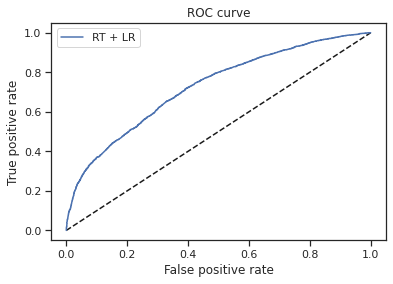

In [32]:
# Xây dựng pipeline và fit với tree-based
selected_columns = cols_categorical+cols_fts_num

class ToString(BaseEstimator, TransformerMixin):
  '''Def 1 trans để convert các cột dạng số như categorical thành dạng cat => dùng được onehot'''
  def fit(self, X, y = None):
    return self
  def transform(self, X, y = None):
    X_ = X.copy() # creating a copy to avoid changes to original dataset
    X_ = X_.astype(str)
    return X_

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing'))
    , ('to_string', ToString())
    , ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
    # , ('standard', StandardScaler()) # Với tree thì không cần standard
])

preprocessing = ColumnTransformer(
    [
     ('cat', categorical_pipe, cols_categorical),
     ('num', numerical_pipe, cols_fts_num)])

rf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

rf.fit(X_train[selected_columns], y_train)

y_pred_rt = rf.predict_proba(X_test[selected_columns])[:, 1]
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)
print('AUC: ', auc(fpr_rt_lm, tpr_rt_lm))

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


In [ ]:
# # SVM
# categorical_pipe = Pipeline([
#     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])
# numerical_pipe = Pipeline([
#     ('imputer', SimpleImputer(strategy='mean'))
#     , ('standard', StandardScaler()) # Với tree thì không cần standard
# ])

# preprocessing = ColumnTransformer(
#     [('cat', categorical_pipe, cols_categorical),
#      ('num', numerical_pipe, cols_fts_num)])

# pipeline = Pipeline([
#     ('preprocess', preprocessing),
#     ('classifier', SVC(probability = True))
# ])
# pipeline.fit(X_train, y_train)

# y_pred_rt = pipeline.predict_proba(X_test)[:, 1]
# fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)
# print('AUC: ', auc(fpr_rt_lm, tpr_rt_lm))

# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve')
# plt.legend(loc='best')
# plt.show()

Epoch 1/8
42/42 [==============================] - 7s 163ms/step - loss: 0.6305 - auc_21: 0.6602 - val_loss: 0.5876 - val_auc_21: 0.6854
Epoch 2/8
42/42 [==============================] - 7s 158ms/step - loss: 0.5667 - auc_21: 0.7134 - val_loss: 0.5816 - val_auc_21: 0.6921
Epoch 3/8
42/42 [==============================] - 7s 159ms/step - loss: 0.5425 - auc_21: 0.7364 - val_loss: 0.5764 - val_auc_21: 0.7020
Epoch 4/8
42/42 [==============================] - 7s 159ms/step - loss: 0.5284 - auc_21: 0.7539 - val_loss: 0.5685 - val_auc_21: 0.7117
Epoch 5/8
42/42 [==============================] - 7s 159ms/step - loss: 0.5193 - auc_21: 0.7638 - val_loss: 0.5693 - val_auc_21: 0.6988
Epoch 6/8
42/42 [==============================] - 7s 159ms/step - loss: 0.5120 - auc_21: 0.7724 - val_loss: 0.5593 - val_auc_21: 0.7119
Epoch 7/8
42/42 [==============================] - 7s 158ms/step - loss: 0.5023 - auc_21: 0.7830 - val_loss: 0.5594 - val_auc_21: 0.7117
Epoch 8/8
42/42 [========================

/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


332/332 [==============================] - 1s 4ms/step
AUC:  0.7111705440072255


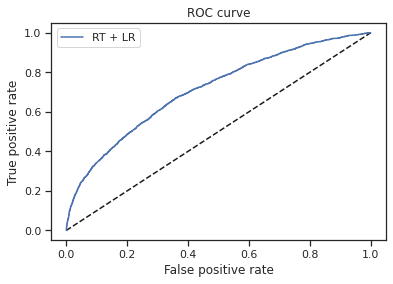

In [72]:
# TF nets
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('to_string', ToString()),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
    # , ('standard', StandardScaler()) # Với tree thì không cần standard
])

preprocessing = ColumnTransformer(
    [('cat', categorical_pipe, cols_categorical),
     ('num', numerical_pipe, cols_fts_num)])

def building_net_func():
  net = Sequential(
      [
      BatchNormalization (),
      Dense(1024, activation ='relu', kernel_initializer = 'he_normal'),
      Dropout(0.5), 
      # BatchNormalization (),
      # Dense(128, activation ='relu', kernel_initializer = 'he_normal'),
      # Dropout(0.25), 
      # BatchNormalization (),
      # Dense(64, activation ='relu', kernel_initializer = 'he_normal'),
      # Dropout(0.25), 
      # BatchNormalization (),
      # Dense(16, activation ='relu', kernel_initializer = 'he_normal'),
      # BatchNormalization (),
      Dense(1, activation ='sigmoid', kernel_initializer = 'he_normal')])
  net.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = [ AUC() ] )
  return net

net = KerasRegressor(build_fn= building_net_func, verbose = 1)

pipeline = Pipeline([
    ('preprocess', preprocessing),
    ('todense', DenseTransformer()),
    ('classifier', net)
])
pipeline.fit(
    pd.concat([X_train, X_test])[selected_columns],
    np.concatenate( [y_train, y_test])
    , classifier__epochs = 8
    , classifier__batch_size = 1024
    , classifier__validation_split = 0.2)

y_pred_rt = pipeline.predict(X_test)
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)
print('AUC: ', auc(fpr_rt_lm, tpr_rt_lm))

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [68]:
prediction = pipeline.predict(predict_data[selected_columns])
res_df = pd.DataFrame({'id': predict_data.id, 'label': prediction})
res_df.to_csv('submission_net.csv', index=False)

637/637 [==============================] - 2s 3ms/step


In [ ]:
# ohe = (rf.named_steps['preprocess']
#          .named_transformers_['cat']
#          .named_steps['onehot'])
# feature_names = ohe.get_feature_names(input_features=cols_categorical)
# feature_names = np.r_[feature_names, cols_fts_num]

# tree_feature_importances = (
#     rf.named_steps['classifier'].feature_importances_)
# sorted_idx = tree_feature_importances.argsort()

# fts_im_num = 15
# y_ticks = np.arange(0, fts_im_num)
# fig, ax = plt.subplots()
# ax.barh(y_ticks, tree_feature_importances[sorted_idx[:fts_im_num]])
# ax.set_yticklabels(feature_names[sorted_idx[:fts_im_num]])
# ax.set_yticks(y_ticks)
# ax.set_title("Random Forest Feature Importances (MDI)")
# fig.tight_layout()
# plt.show()

In [ ]:
sorted_idx[:15]

Dự đoán kết quả

In [37]:
prediction = rf.predict_proba(predict_data[selected_columns])[:, 1]
res_df = pd.DataFrame({'id': predict_data.id, 'label': prediction})
res_df.to_csv('submission.csv', index=False)

In [36]:
prediction

array([0.24803742, 0.31890366, 0.4028687 , ..., 0.10729143, 0.26460362,
       0.19883522])